In [1]:
# MLP : Bengio et al. 2003 - https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [197]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

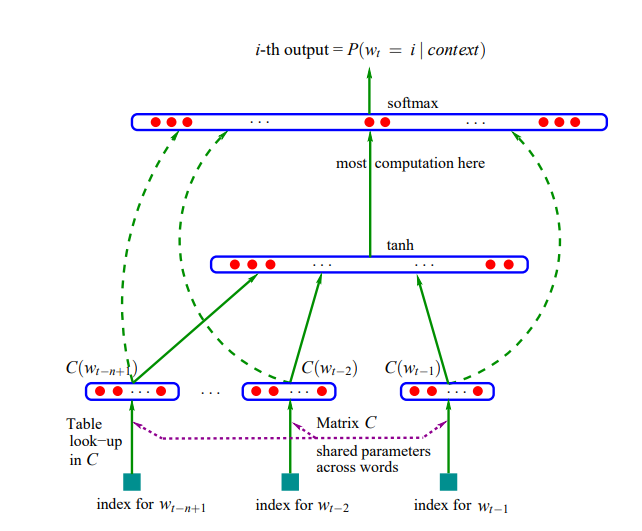

In [198]:
# read in all the names:
words = open("names.txt", "r").read().splitlines()
len(words)

32033

In [199]:
# Create a look up list for unique characters
chars = sorted(list(set(''.join(words))))# ''.join(words) will concatenate all the strings in 'words', then put it into a set
stoi = {s:i+1 for i,s in enumerate(chars)} # enumerate creates an iterator for the list and add index for the items
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [200]:
# Build the dataset:

block_size = 3 # context length: Basically how many characters do we take to predict the next one?
X, Y = [], [] # X - input, Y - label
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context),':',context, '--->', itos[ix], ':', [ix]) # For example: '0' is the index of '.'
        context = context[1:] + [ix] # crop and append: Always crop the first character and append a new one to the end
        
X = torch.tensor(X)
Y = torch.tensor(Y)

print("Size of input: ", len(X))

emma
... : [0, 0, 0] ---> e : [5]
..e : [0, 0, 5] ---> m : [13]
.em : [0, 5, 13] ---> m : [13]
emm : [5, 13, 13] ---> a : [1]
mma : [13, 13, 1] ---> . : [0]
olivia
... : [0, 0, 0] ---> o : [15]
..o : [0, 0, 15] ---> l : [12]
.ol : [0, 15, 12] ---> i : [9]
oli : [15, 12, 9] ---> v : [22]
liv : [12, 9, 22] ---> i : [9]
ivi : [9, 22, 9] ---> a : [1]
via : [22, 9, 1] ---> . : [0]
ava
... : [0, 0, 0] ---> a : [1]
..a : [0, 0, 1] ---> v : [22]
.av : [0, 1, 22] ---> a : [1]
ava : [1, 22, 1] ---> . : [0]
isabella
... : [0, 0, 0] ---> i : [9]
..i : [0, 0, 9] ---> s : [19]
.is : [0, 9, 19] ---> a : [1]
isa : [9, 19, 1] ---> b : [2]
sab : [19, 1, 2] ---> e : [5]
abe : [1, 2, 5] ---> l : [12]
bel : [2, 5, 12] ---> l : [12]
ell : [5, 12, 12] ---> a : [1]
lla : [12, 12, 1] ---> . : [0]
sophia
... : [0, 0, 0] ---> s : [19]
..s : [0, 0, 19] ---> o : [15]
.so : [0, 19, 15] ---> p : [16]
sop : [19, 15, 16] ---> h : [8]
oph : [15, 16, 8] ---> i : [9]
phi : [16, 8, 9] ---> a : [1]
hia : [8, 9, 1] ---> . :

In [201]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [202]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [203]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [204]:
# Create the lookup table for the characters
C = torch.randn((27, 2)) # Each row has a 2 dimensional embedding, in the paper of MLP, they could use for example 30 dimension instead of 2.
C

tensor([[ 0.2619, -1.1753],
        [ 2.5274, -1.2949],
        [ 1.3672, -0.8499],
        [ 1.5401, -0.8105],
        [-0.4011, -0.0566],
        [ 0.1350,  0.1328],
        [ 0.7094,  0.4870],
        [-0.3894, -1.3304],
        [ 0.6502, -0.6780],
        [ 2.5044, -0.0571],
        [-0.1454,  0.5768],
        [ 0.8389, -2.0524],
        [-1.6630, -0.7575],
        [ 0.3147, -1.5214],
        [ 1.0152,  0.9525],
        [ 0.5769,  0.7545],
        [ 2.4882, -0.8130],
        [-0.4157,  0.4580],
        [ 0.6421,  0.2253],
        [ 2.0787,  0.1622],
        [ 0.2989, -0.0766],
        [ 0.1425, -0.3824],
        [ 1.4308,  0.9920],
        [-0.9970, -0.7841],
        [-1.2000,  0.3072],
        [-0.1917,  0.3106],
        [ 0.4262,  0.2081]])

In [205]:
F.one_hot(torch.tensor(5), num_classes=27) # Creates a one-hot vector and the 5th dimension is 1
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # This is equivalent to C[5]

tensor([0.1350, 0.1328])

In [206]:
C[[5,6,7]] # Gets the row: 5,6,7

tensor([[ 0.1350,  0.1328],
        [ 0.7094,  0.4870],
        [-0.3894, -1.3304]])

In [207]:
C[X] # Same as above, to get multiple rows. For example X[0] = [0,0,0] , C[X[0]] or X[X][0] = [C[0], C[0], C[0]]

tensor([[[ 0.2619, -1.1753],
         [ 0.2619, -1.1753],
         [ 0.2619, -1.1753]],

        [[ 0.2619, -1.1753],
         [ 0.2619, -1.1753],
         [ 0.1350,  0.1328]],

        [[ 0.2619, -1.1753],
         [ 0.1350,  0.1328],
         [ 0.3147, -1.5214]],

        [[ 0.1350,  0.1328],
         [ 0.3147, -1.5214],
         [ 0.3147, -1.5214]],

        [[ 0.3147, -1.5214],
         [ 0.3147, -1.5214],
         [ 2.5274, -1.2949]],

        [[ 0.2619, -1.1753],
         [ 0.2619, -1.1753],
         [ 0.2619, -1.1753]],

        [[ 0.2619, -1.1753],
         [ 0.2619, -1.1753],
         [ 0.5769,  0.7545]],

        [[ 0.2619, -1.1753],
         [ 0.5769,  0.7545],
         [-1.6630, -0.7575]],

        [[ 0.5769,  0.7545],
         [-1.6630, -0.7575],
         [ 2.5044, -0.0571]],

        [[-1.6630, -0.7575],
         [ 2.5044, -0.0571],
         [ 1.4308,  0.9920]],

        [[ 2.5044, -0.0571],
         [ 1.4308,  0.9920],
         [ 2.5044, -0.0571]],

        [[ 1.4308,  0

In [208]:
C[X][0]

tensor([[ 0.2619, -1.1753],
        [ 0.2619, -1.1753],
        [ 0.2619, -1.1753]])

In [14]:
C[X][12,2] 

tensor([0.4944, 2.3685])

In [15]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [16]:
W1 = torch.randn((6, 100)) # 6 because we have from the emb shape that 3 x 2, and each neuron in the embeddings need weight to the next neurons
b1 = torch.randn(100)

In [17]:
emb @ W1 + b1 # Wrong dimension -> [32, 3, 2] @ [6, 100] cannot be multiplied so the 3, 2 needs to be crunched to be 6

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [18]:
# concetanate
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

# https://pytorch.org/docs/stable/generated/torch.unbind.html - unbind removes a tensor dimension
torch.cat(torch.unbind(emb, 1), 1).shape # This way it is much less efficient, since it will allocate new memory

torch.Size([32, 6])

In [19]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [20]:
a.shape

torch.Size([18])

In [21]:
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
# Great article about these python internals: http://blog.ezyang.com/2019/05/pytorch-internals/
# .view is really efficient, since it just modifies the logical output of the physical order
a.view(2, 9) # Convert it to a 2x9 tensor

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [22]:
emb.view(32,6)

tensor([[ 0.4944,  2.3685,  0.4944,  2.3685,  0.4944,  2.3685],
        [ 0.4944,  2.3685,  0.4944,  2.3685,  0.0503,  0.2492],
        [ 0.4944,  2.3685,  0.0503,  0.2492,  0.3279, -1.0698],
        [ 0.0503,  0.2492,  0.3279, -1.0698,  0.3279, -1.0698],
        [ 0.3279, -1.0698,  0.3279, -1.0698,  1.2812,  1.2163],
        [ 0.4944,  2.3685,  0.4944,  2.3685,  0.4944,  2.3685],
        [ 0.4944,  2.3685,  0.4944,  2.3685, -0.6892, -0.5062],
        [ 0.4944,  2.3685, -0.6892, -0.5062,  0.5413, -0.5218],
        [-0.6892, -0.5062,  0.5413, -0.5218, -0.3712, -0.2591],
        [ 0.5413, -0.5218, -0.3712, -0.2591,  0.6875, -0.7846],
        [-0.3712, -0.2591,  0.6875, -0.7846, -0.3712, -0.2591],
        [ 0.6875, -0.7846, -0.3712, -0.2591,  1.2812,  1.2163],
        [ 0.4944,  2.3685,  0.4944,  2.3685,  0.4944,  2.3685],
        [ 0.4944,  2.3685,  0.4944,  2.3685,  1.2812,  1.2163],
        [ 0.4944,  2.3685,  1.2812,  1.2163,  0.6875, -0.7846],
        [ 1.2812,  1.2163,  0.6875, -0.7

In [23]:
# Now this will work perfectly since the dimensions will be perfect
# -1 as the first parameter: python will fill out logically what should be there since it knows that the number of elements should be the same after calling the view 
# '+ b1' : should pay attention because of the broadcasting should be correct, since it is a [1, 100] tensor, it will vertically add to the 'emb.view(-1,6) @ W1'
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
print(h)
h.shape

tensor([[-0.9211,  0.7548,  0.9648,  ...,  0.9104,  0.9757, -0.1233],
        [-0.8988,  0.6475,  0.9959,  ..., -0.7814,  0.9988,  0.9935],
        [-0.9978,  0.9979,  0.9779,  ..., -0.9947,  0.9307,  0.9545],
        ...,
        [ 0.5768,  0.2309,  0.9306,  ..., -0.9956,  0.5712,  0.8710],
        [ 0.9168,  0.7648,  0.9156,  ..., -0.9131,  0.5828,  0.1573],
        [ 0.3000,  0.9331,  0.1079,  ...,  0.1927, -0.9953, -0.6175]])


torch.Size([32, 100])

In [24]:
W2 = torch.randn((100, 27)) # 27, because we have 27 possible character to come next
b2 = torch.randn(27) 

In [25]:
logits = h @ W2 + b2

In [26]:
logits.shape

torch.Size([32, 27])

In [27]:
logits

tensor([[ 7.9803e+00,  9.6862e-01, -4.9641e+00, -9.5588e+00,  1.5360e+00,
          1.0987e+00,  5.4704e+00,  1.3848e-01,  1.7614e+01,  1.6008e+00,
         -9.0356e-01,  3.5205e+00,  1.0784e+01,  1.5273e+01,  2.5533e+00,
         -9.8006e+00,  6.3478e-01, -1.1857e+01, -1.0408e+00,  5.5839e+00,
         -3.9903e+00, -6.9324e+00, -3.0960e-01, -1.7512e+01,  3.7734e-01,
          1.5562e+01,  3.7600e+00],
        [ 7.8197e+00,  5.3924e+00, -1.0586e+01, -9.5668e+00,  6.3506e+00,
         -1.3898e+00,  7.9803e+00, -2.2148e+00,  2.3421e+01, -3.1309e-01,
          2.0764e+00, -2.5766e+00,  1.1659e+01,  9.7637e+00,  1.3942e+01,
         -6.7821e+00, -1.7656e-01,  5.6033e+00,  3.9521e+00,  8.3908e+00,
         -8.3087e+00, -3.8636e+00,  8.6681e-01, -1.8893e+01, -3.9278e+00,
          4.6075e+00,  1.2965e+00],
        [ 3.4590e+00,  7.0478e+00, -2.7700e+00, -4.6987e+00, -2.4790e+00,
         -9.3731e-01, -3.0278e+00,  9.1386e+00,  2.3199e+01,  5.6272e+00,
          1.4176e+00, -1.0127e+01, -2.37

In [28]:
counts = logits.exp()

In [29]:
prob = counts / counts.sum(1, keepdims=True)
print(prob.shape)
prob[0].sum() # Normalized to probability
prob # Each dimension contains the probability to which character should come next

torch.Size([32, 27])


tensor([[5.3437e-05, 4.8165e-08, 1.2770e-10, 1.2904e-12, 8.4947e-08, 5.4856e-08,
         4.3435e-06, 2.0999e-08, 8.1568e-01, 9.0630e-08, 7.4071e-09, 6.1799e-07,
         8.8222e-04, 7.8551e-02, 2.3493e-07, 1.0133e-12, 3.4494e-08, 1.2960e-13,
         6.4574e-09, 4.8654e-06, 3.3813e-10, 1.7838e-11, 1.3415e-08, 4.5352e-16,
         2.6665e-08, 1.0483e-01, 7.8522e-07],
        [1.6757e-07, 1.4792e-08, 1.7008e-15, 4.7134e-15, 3.8566e-08, 1.6771e-11,
         1.9678e-07, 7.3498e-12, 9.9991e-01, 4.9224e-11, 5.3691e-10, 5.1185e-12,
         7.7936e-06, 1.1707e-06, 7.6383e-05, 7.6335e-14, 5.6425e-11, 1.8266e-08,
         3.5036e-09, 2.9665e-07, 1.6586e-14, 1.4132e-12, 1.6018e-10, 4.1968e-19,
         1.3253e-12, 6.7478e-09, 2.4615e-10],
        [2.6723e-09, 9.6714e-08, 5.2678e-12, 7.6566e-13, 7.0477e-12, 3.2929e-11,
         4.0707e-12, 7.8249e-07, 9.9965e-01, 2.3362e-08, 3.4697e-10, 3.3600e-15,
         7.8279e-12, 1.6118e-10, 7.4053e-08, 4.5067e-15, 4.6566e-10, 3.0585e-07,
         4.4975e-

In [30]:
# torch.arange(32) will go through each 32 dimension (iterates the rows) and and Y - label by each row grabs that column as given by Y, gives back the probability of that character we would like to predict
prob[torch.arange(32), Y]

tensor([5.4856e-08, 1.1707e-06, 1.6118e-10, 2.6283e-06, 2.5399e-11, 1.0133e-12,
        7.6405e-05, 6.8387e-06, 9.9532e-03, 4.3050e-12, 5.7339e-05, 5.7251e-12,
        4.8165e-08, 3.9943e-06, 5.6054e-05, 8.4464e-11, 9.0630e-08, 4.6242e-08,
        4.8716e-07, 5.5380e-02, 2.3057e-08, 2.9076e-02, 1.4466e-12, 2.5191e-06,
        4.5381e-11, 4.8654e-06, 3.0588e-14, 7.9599e-08, 1.7370e-03, 4.2944e-08,
        1.8910e-08, 2.4143e-12])

In [31]:
# Calculate the loss - the function we would like to minimize is the loss function
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.5948)

### Clean version

In [32]:
block_size = 3 # context length: Basically how many characters do we take to predict the next one?
X, Y = [], [] # X - input, Y - label
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append: Always crop the first character and append a new one to the end
        
X = torch.tensor(X)
Y = torch.tensor(Y)

size = len(X)

print("Size of input: ", len(X))

Size of input:  228146


In [33]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [34]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [35]:
sum(p.nelement() for p in parameters) # Number of parameters in total

3481

In [36]:
# Creating a list of possible learning rates,between 0 and 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [37]:
for p in parameters:
    p.requires_grad = True

In [209]:
lri = []
lossi = []

for i in range(10000):
    
    # Minibatch construction - it is needed to optimize, since the whole dataset is too large for that many iteration
    ix = torch.randint(0, X.shape[0], (32,)) # mini batch size is 32
    
    # Forward pass:
    emb = C[X[ix]] # For example: [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 100] @ [100, 27] = [32, 27]
    # Cross-entropy function: ------------------------
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # ------------------------------------------------
    # F.cross_entropy(arg1, arg2) - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html - is equivalent to above:
    loss = F.cross_entropy(logits, Y[ix])
    if i % 1000 == 0:
        print(loss.item())

    # Backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update:
    # lr = lrs[i]
    lr = 0.01 # Based on the diagram 10**-1=0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats:
    # lri.append(lre[i])
    # lossi.append(loss.item())
        
print(f'Final loss for the mini batch: {loss.item()}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x6 and 30x200)

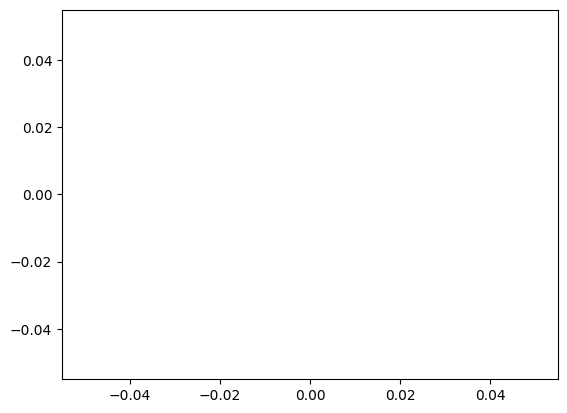

In [41]:
# Plot the stats:
plt.plot(lri, lossi)

In [42]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y)

print(f'Final loss for the whole dataset: {loss.item()}')

Final loss for the whole dataset: 2.572760581970215


## Split our dataset:

#### training split / dev/validation split / test split
#### 80%, 10%, 10%

In [210]:
def build_dataset(words):
    block_size = 3
    X, Y = [], [] 
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [211]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [227]:
lri = []
lossi = []
stepi = []

def training_ntw(epoch, X, Y, lr, track_lri=False, track_loss=False, track_step=False):
    for i in range(epoch):
        ix = torch.randint(0, X.shape[0], (32,)) # mini batch size is 32
    
        # Forward pass:
        emb = C[X[ix]] # For example: [32, 3, 2]
        h = torch.tanh(emb.view(-1, 90) @ W1 + b1) # [32, 100]
        logits = h @ W2 + b2 # [32, 100] @ [100, 27] = [32, 27]
        
        # Cross-entropy function: 
        loss = F.cross_entropy(logits, Y[ix])

        # Backward pass:
        for p in parameters:
            p.grad = None
        loss.backward()

        # Update:
        for p in parameters:
            p.data += -lr * p.grad

        # Track stats:
        if track_lri == True: lri.append(lre[i])
        if track_loss == True: lossi.append(loss.log10().item())
        if track_step == True: stepi.append(i)

        
    print(f'Final loss for the mini batches: {loss.item()}')

def eval(X, Y):
    emb = C[X] 
    h = torch.tanh(emb.view(-1, 90) @ W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y)
    print(f'Final loss for the whole dataset: {loss.item()}')

## Scale up the neural network:

In [228]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 30), generator=g)
W1 = torch.randn((90, 300), generator=g) # 30 it is because the block size x the second dimension of C
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [229]:
for p in parameters:
    p.requires_grad = True

In [230]:
sum(p.nelement() for p in parameters) # Number of parameters in total

36237

In [241]:
training_ntw(20000, Xtr, Ytr, 0.01, track_loss=True, track_step=True)

Final loss for the mini batches: 2.0671236515045166


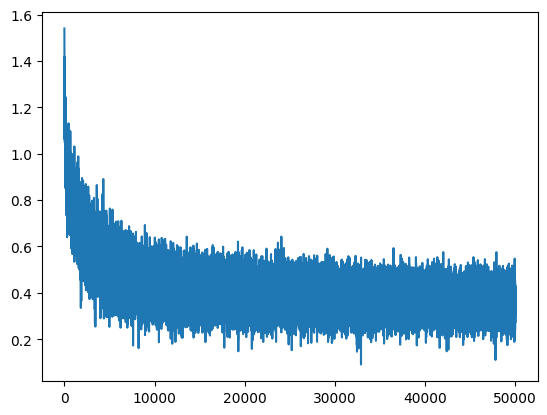

In [232]:
plt.plot(stepi, lossi)

In [242]:
eval(Xtr, Ytr)

Final loss for the whole dataset: 2.080867290496826


In [243]:
eval(Xdev, Ydev)

Final loss for the whole dataset: 2.1963374614715576


In [239]:
C[:,0]

tensor([ 1.3543, -1.9410, -0.0294, -1.8458, -0.0835, -0.1945,  0.5199, -0.8887,
         0.5839,  0.3205, -1.6468, -0.0778, -1.3637,  0.6102, -0.9077, -1.5209,
        -0.2353, -1.1741,  3.4600,  2.6613,  0.8527, -0.4072,  0.1683, -0.2237,
         0.4742, -0.3606, -0.4870], grad_fn=<SelectBackward0>)

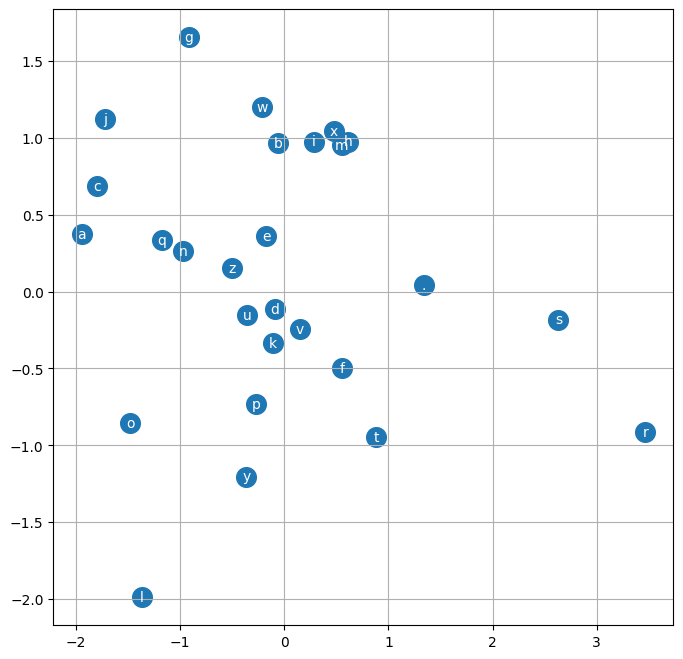

In [244]:
# Creating a figure to visualize the embeddings trained by the neural network
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [245]:
eval(Xte, Yte)

Final loss for the whole dataset: 2.1879682540893555


## Test the name generation:

In [295]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 12)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,dimension) - For example: [1, 3, 30]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) # - For example: [1, 90] * [90, 300] =  [1, 300] + [1, 300]
      logits = h @ W2 + b2 # - For example: [1, 300] * [300, 27] = [1, 27] + [1, 27]
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

zaerianna.
nasia.
xali.
cereeden.
kesha.
kelanith.
ulei.
prendro.
staciraj.
abriyah.
journ.
paisa.
issa.
berlyliya.
rey.
seia.
anan.
shad.
maelah.
arhanee.
